In [1]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import os

In [2]:
imdb_filepath = "../data/im.db.zip"
extract_to_data = "../data"

In [3]:
# Open the zip file
with zipfile.ZipFile(imdb_filepath, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to_data)

In [4]:
con = sqlite3.connect('../data/im.db')

In [5]:
imdb_schema = pd.read_sql("""

SELECT *
FROM sqlite_master

""", con)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
rating_info_comb_5k = pd.read_sql("""

SELECT *
FROM movie_basics AS b
    JOIN movie_ratings AS r
        ON b.movie_id = r.movie_id
WHERE numvotes > 5000

""", con)

In [7]:
tn_movie_budgets_df = pd.read_csv("../Data/tn.movie_budgets.csv")
tn_movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
rating_info_comb_5k.rename(columns={'primary_title':'movie'}, inplace=True)

In [9]:
info_budget_df = pd.merge(rating_info_comb_5k, tn_movie_budgets_df, on='movie')

In [10]:
info_budget_df["production_budget"] = info_budget_df["production_budget"].replace('[\$,]', '', regex=True).astype(int)

In [11]:
info_budget_df["domestic_gross"] = info_budget_df["domestic_gross"].replace('[\$,]', '', regex=True).astype(int)

In [12]:
info_budget_df["worldwide_gross"] = info_budget_df["worldwide_gross"].replace('[\$,]', '', regex=True).astype(int)

In [13]:
info_budget_df['net_revenue'] = info_budget_df["worldwide_gross"] - info_budget_df["production_budget"]

In [14]:
info_budget_df['ROI%'] = info_budget_df['net_revenue'] / info_budget_df["production_budget"]

In [15]:
info_budget_df.drop(columns=['movie_id', 'original_title', 'id', 'start_year', 'release_date'], inplace=True)

In [16]:
info_budget_df.columns

Index(['movie', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'net_revenue',
       'ROI%'],
      dtype='object')

In [17]:
info_budget_df.describe()

,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,net_revenue,ROI%
count,1528.000000,1528.000000,1.528000e+03,1.528000e+03,1.528000e+03,1.528000e+03,1.528000e+03,1528.000000
mean,108.890052,6.420157,1.241817e+05,4.568621e+07,5.879711e+07,1.462186e+08,1.005324e+08,3.431990
std,16.909512,0.927884,1.636752e+05,5.554199e+07,8.581981e+07,2.349052e+08,1.951454e+08,14.001372
min,63.000000,1.600000,5.058000e+03,2.500000e+04,0.000000e+00,0.000000e+00,-2.002376e+08,-1.000000
25%,96.000000,5.800000,2.643475e+04,1.000000e+07,5.714093e+06,1.319630e+07,-1.344542e+05,-0.049749
50%,106.000000,6.500000,6.906000e+04,2.500000e+07,3.055370e+07,5.799648e+07,2.725720e+07,1.296006
75%,118.000000,7.100000,1.530615e+05,5.800000e+07,7.143998e+07,1.647563e+08,1.111535e+08,3.244119
max,180.000000,8.800000,1.841066e+06,4.106000e+08,7.000596e+08,2.048134e+09,1.748134e+09,415.564740


In [18]:
info_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1528 non-null   object 
 1   runtime_minutes    1528 non-null   float64
 2   genres             1528 non-null   object 
 3   averagerating      1528 non-null   float64
 4   numvotes           1528 non-null   int64  
 5   production_budget  1528 non-null   int64  
 6   domestic_gross     1528 non-null   int64  
 7   worldwide_gross    1528 non-null   int64  
 8   net_revenue        1528 non-null   int64  
 9   ROI%               1528 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 119.5+ KB


In [19]:
# Assuming df is your DataFrame
duplicates = info_budget_df[info_budget_df.groupby(['movie', 'runtime_minutes', 'genres'])['production_budget'].transform('count') > 1]

print(f'{len(duplicates)}: {duplicates}')

110:                           movie  runtime_minutes                    genres  \
50               The Karate Kid            140.0       Action,Drama,Family   
51               The Karate Kid            140.0       Action,Drama,Family   
69    A Nightmare on Elm Street             95.0        Crime,Drama,Horror   
70    A Nightmare on Elm Street             95.0        Crime,Drama,Horror   
74                     Hercules             98.0  Action,Adventure,Fantasy   
...                         ...              ...                       ...   
1429                    RoboCop            117.0       Action,Crime,Sci-Fi   
1431               Ghostbusters            116.0     Action,Comedy,Fantasy   
1432               Ghostbusters            116.0     Action,Comedy,Fantasy   
1482             Fantastic Four            100.0    Action,Adventure,Drama   
1483             Fantastic Four            100.0    Action,Adventure,Drama   

      averagerating  numvotes  production_budget  domestic

In [20]:
info_budget_df = info_budget_df.drop_duplicates(subset=['movie', 'runtime_minutes', 'genres'])
info_budget_df.shape

(1472, 10)

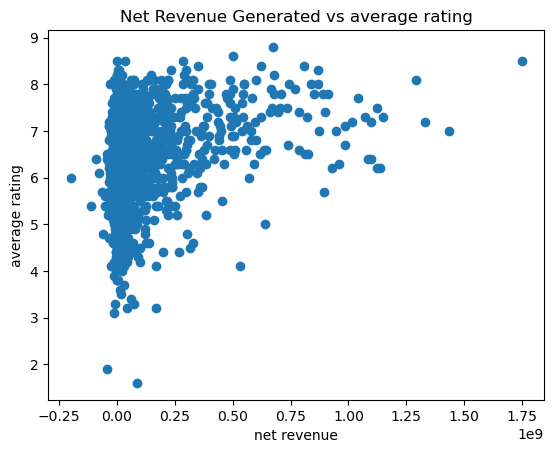

In [21]:
import matplotlib.pyplot as plt

plt.scatter(info_budget_df['net_revenue'], info_budget_df['averagerating'])
plt.title('Net Revenue Generated vs average rating')
plt.xlabel('net revenue')
plt.ylabel('average rating')
plt.savefig("../Images/netrev_vs_avgrating_scatter.png", bbox_inches='tight')
plt.show()

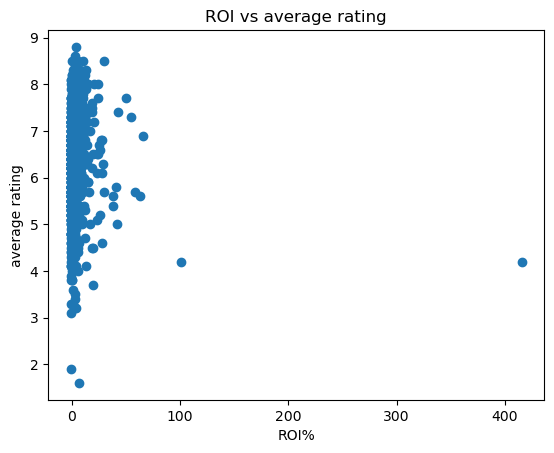

In [22]:
plt.scatter(info_budget_df['ROI%'], info_budget_df['averagerating'])
plt.title('ROI vs average rating')
plt.xlabel('ROI%')
plt.ylabel('average rating')
plt.savefig("../Images/roi_vs_avgrating_scatter.png", bbox_inches='tight')
plt.show()

In [23]:
all_genres = info_budget_df['genres'].str.split(',').explode()
unique_genres = all_genres.unique()
unique_genres

array(['Action', 'Adventure', 'Fantasy', 'Comedy', 'Biography', 'Drama',
       'Sport', 'Romance', 'Crime', 'Horror', 'Thriller', 'Family',
       'Sci-Fi', 'Mystery', 'History', 'Animation', 'Documentary', 'War',
       'Music', 'Musical', 'Western'], dtype=object)

In [24]:
def create_genre_dataframe(df, genre):
    """
    Creates a dataframe containing only the rows where the specified genre is one of the genres.

    :param df: The original dataframe with movie data.
    :param genre: The genre to filter by.
    :return: A dataframe containing only rows with the specified genre.
    """
    # Filter rows where the genre column contains the specified genre
    genre_df = df[df['genres'].astype(str).str.contains(genre, na=False)]
    return genre_df

In [25]:
horror_df = create_genre_dataframe(info_budget_df, 'Horror')
action_df = create_genre_dataframe(info_budget_df, 'Action')
adventure_df = create_genre_dataframe(info_budget_df, 'Adventure')
fantasy_df = create_genre_dataframe(info_budget_df, 'Fantasy')
scifi_df = create_genre_dataframe(info_budget_df, 'Sci-Fi')
thriller_df = create_genre_dataframe(info_budget_df, 'Thriller')
western_df = create_genre_dataframe(info_budget_df, 'Western')
animation_df = create_genre_dataframe(info_budget_df, 'Animation')
comedy_df = create_genre_dataframe(info_budget_df, 'Comedy')
family_df = create_genre_dataframe(info_budget_df, 'Family')
crime_df = create_genre_dataframe(info_budget_df, 'Crime')
drama_df = create_genre_dataframe(info_budget_df, 'Drama')
romance_df = create_genre_dataframe(info_budget_df, 'Romance')
mystery_df = create_genre_dataframe(info_budget_df, 'Mystery')
history_df = create_genre_dataframe(info_budget_df, 'History')
sports_df = create_genre_dataframe(info_budget_df, 'Sport')
biography_df = create_genre_dataframe(info_budget_df, 'Biography')
war_df = create_genre_dataframe(info_budget_df, 'War')
musical_df = create_genre_dataframe(info_budget_df, 'Musical')
documentary_df = create_genre_dataframe(info_budget_df, 'Documentary')
music_df = create_genre_dataframe(info_budget_df, 'Music')
news_df = create_genre_dataframe(info_budget_df, 'News')

In [26]:
genre_df_dict = {'Horror': horror_df, 'Action': action_df, 'Adventure': adventure_df, 'Fantasy': fantasy_df, 'Sci-Fi': scifi_df, 'Thriller': thriller_df,
       'Western': western_df, 'Animation': animation_df, 'Comedy': comedy_df, 'Family': family_df, 'Crime': crime_df, 'Drama': drama_df,
       'Romance': romance_df, 'Mystery': mystery_df, 'History': history_df, 'Sport': sports_df, 'Biography': biography_df, 'War': war_df,
       'Musical': musical_df, 'Documentary': documentary_df, 'Music': music_df, 'News': news_df}

In [27]:
genre_ROI_df_dict= {'Horror': horror_df['ROI%'], 'Action': action_df['ROI%'], 'Adventure': adventure_df['ROI%'], 
                    'Fantasy': fantasy_df['ROI%'], 'Sci-Fi': scifi_df['ROI%'], 'Thriller': thriller_df['ROI%'], 
                    'Western': western_df['ROI%'], 'Animation': animation_df['ROI%'], 'Comedy': comedy_df['ROI%'], 
                    'Family': family_df['ROI%'], 'Crime': crime_df['ROI%'],
                    'Drama': drama_df['ROI%'], 'Romance': romance_df['ROI%'], 'Mystery': mystery_df['ROI%'], 
                    'History': history_df['ROI%'], 'Sport': sports_df['ROI%'],
                    'Biography': biography_df['ROI%'], 'War': war_df['ROI%'], 'Musical': musical_df['ROI%'], 
                    'Documentary': documentary_df['ROI%'], 'Music': music_df['ROI%'], 'News': news_df['ROI%']}
len(genre_ROI_df_dict)

22

In [28]:
genre_count = [(genre, len(i)) for genre, i in genre_ROI_df_dict.items()]
genre_count.sort(key=lambda tup: tup[1], reverse=True)
top_15_genres = genre_count[:15]
top_15_genres

[('Drama', 753),
 ('Comedy', 511),
 ('Action', 440),
 ('Adventure', 358),
 ('Thriller', 274),
 ('Crime', 248),
 ('Romance', 195),
 ('Horror', 186),
 ('Sci-Fi', 147),
 ('Biography', 141),
 ('Mystery', 136),
 ('Fantasy', 127),
 ('Animation', 99),
 ('Family', 77),
 ('Music', 50)]

In [29]:
net_rev_df = pd.DataFrame(info_budget_df.groupby('movie').net_revenue.sum())

In [30]:
netrev_sorted_df = net_rev_df.sort_values('net_revenue', ascending=False)

In [31]:
netrev_sorted_df

,net_revenue
movie,
Frozen,2244939820
Beauty and the Beast,2198399412
Avengers: Infinity War,1748134200
Jurassic World,1433854864
Furious 7,1328722794
...,...
Shanghai,-68988156
The Promise,-79448583
Bright,-90000000


In [32]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [33]:
from scipy.stats import kruskal

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [35]:
for x, y in genre_ROI_df_dict.items():
    average_roi = y.mean()
    print(f'{x}: {average_roi}')

Horror: 9.298232730826173
Action: 1.860011371896121
Adventure: 2.2026224561624628
Fantasy: 2.1065943894884724
Sci-Fi: 2.6018832911474656
Thriller: 5.720278250554301
Western: 0.38193258119384244
Animation: 2.958521739339202
Comedy: 2.3686602660052603
Family: 2.061976984211789
Crime: 1.0527215275990975
Drama: 2.330724692940332
Romance: 2.6448561309128333
Mystery: 9.282766285089451
History: 1.4098471332215325
Sport: 1.4554377914207526
Biography: 2.4789176916687357
War: 0.7546614552406627
Musical: 2.536316095324262
Documentary: 2.518073901365174
Music: 2.96211333537838
News: nan


In [36]:
import matplotlib.pyplot as plt

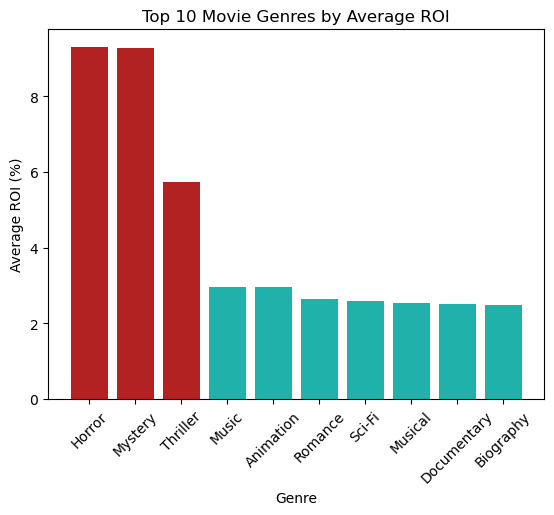

In [37]:
# Calculate the average ROI for each genre
genre_average_roi = {genre: df.mean() for genre, df in genre_ROI_df_dict.items()}

# Sort the genres by their average ROI in descending order and take the top 10
sorted_genre_average_roi = dict(
        sorted(genre_average_roi.items(),
        key=lambda item: item[1], reverse=True)[:10])

# Unpack the genres and their ROIs into separate lists
genres = list(sorted_genre_average_roi.keys())
average_rois = list(sorted_genre_average_roi.values())
colors = ['firebrick' if average_rois > 4 else 'lightseagreen' for average_rois in average_rois]

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, average_rois, color=colors)
plt.xlabel('Genre')
plt.ylabel('Average ROI (%)')
plt.title('Top 10 Movie Genres by Average ROI')
plt.xticks(rotation=45)
plt.savefig("../Images/top10genres_avgroi_barchart.png", bbox_inches='tight')
plt.show()

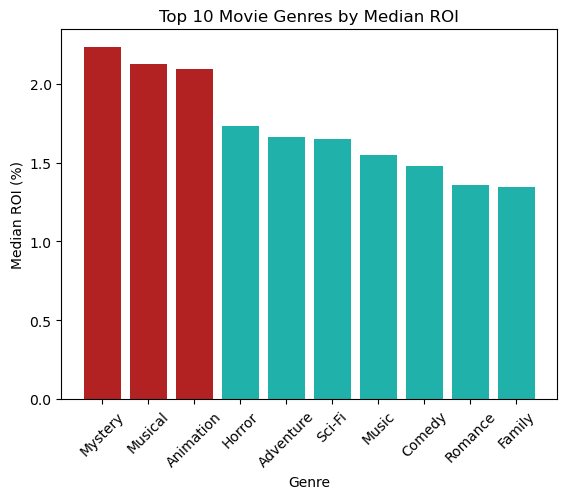

In [38]:
genre_median_roi = {genre: df.median() for genre, df in genre_ROI_df_dict.items()}
sorted_genre_median_roi = dict(sorted(genre_median_roi.items(), key=lambda item: item[1], reverse=True)[:10])
genres = list(sorted_genre_median_roi.keys())
median_rois = list(sorted_genre_median_roi.values())
colors = ['firebrick' if median_rois > 2 else 'lightseagreen' for median_rois in median_rois]

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, median_rois, color=colors)
plt.xlabel('Genre')
plt.ylabel('Median ROI (%)')
plt.title('Top 10 Movie Genres by Median ROI')
plt.xticks(rotation=45)
plt.savefig("../Images/top10genres_medianroi_barchart.png", bbox_inches='tight')
plt.show()

In [39]:
import seaborn as sns

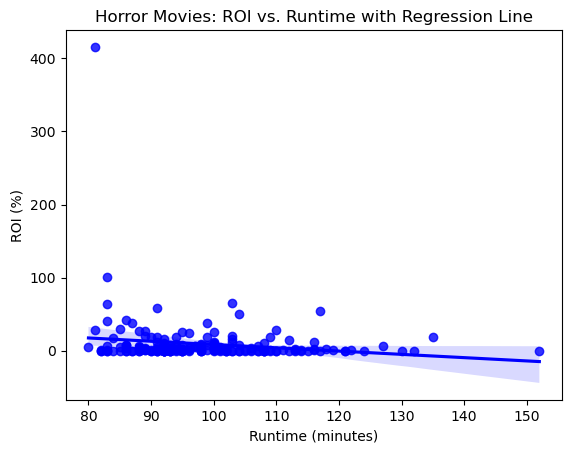

In [40]:
plt.figsize=(8, 6)
sns.regplot(x='runtime_minutes', y='ROI%', data=horror_df, color='blue')
plt.title('Horror Movies: ROI vs. Runtime with Regression Line')
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.savefig("../Images/horror_regplot_outliers.png", bbox_inches='tight')
plt.show()

In [41]:
horror_df['ROI%'].quantile(0.25)

-0.27315579887218044

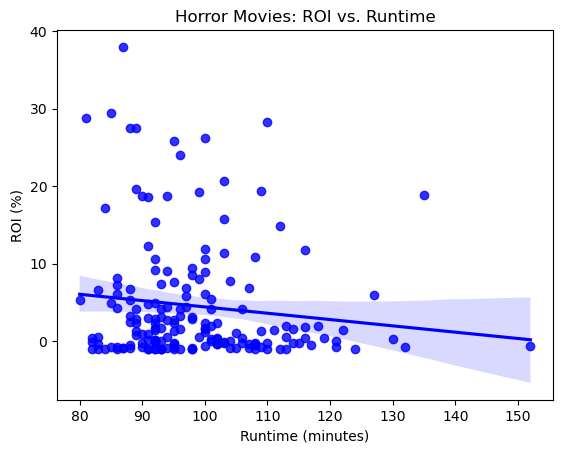

In [42]:
lower = horror_df['ROI%'].quantile(0.01)
upper = horror_df['ROI%'].quantile(0.95)

# Filter out the outliers
filtered_horror_df = horror_df[~((horror_df['ROI%'] < lower) | (horror_df['ROI%'] > upper))]

plt.figsize=(8, 6)
sns.regplot(x='runtime_minutes', y='ROI%', data=filtered_horror_df, color='blue')
plt.title('Horror Movies: ROI vs. Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.savefig("../Images/horror_regplot_sans_outliers.png", bbox_inches='tight')
plt.show()

In [43]:
# Filter for specific genres: Horror, Thriller, and Mystery
dark_genres_to_include = ['Horror', 'Thriller', 'Mystery']
dark_movies = info_budget_df[info_budget_df['genres'].str.contains('|'.join(dark_genres_to_include), na=False)]

# Calculate the maximum runtime for defining the upper limit of the bins
max_runtime = dark_movies['runtime_minutes'].max()

# Define runtime bins of 20 minutes each
bin_width = 20
bins = list(range(0, int(max_runtime) + bin_width, bin_width))

# Generate labels for the bins
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Bin the runtime data
dark_movies['runtime_bin'] = pd.cut(dark_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)

# Group by the new bins and calculate mean ROI
dark_grouped_data = dark_movies.groupby('runtime_bin', observed=True)['ROI%'].mean()

# Print the result
print(dark_grouped_data)

runtime_bin
60-80      5.082696
80-100     7.649524
100-120    3.025244
120-140    2.188443
140-160    2.060293
160-180    0.899972
Name: ROI%, dtype: float64


/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/567716112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dark_movies['runtime_bin'] = pd.cut(dark_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)


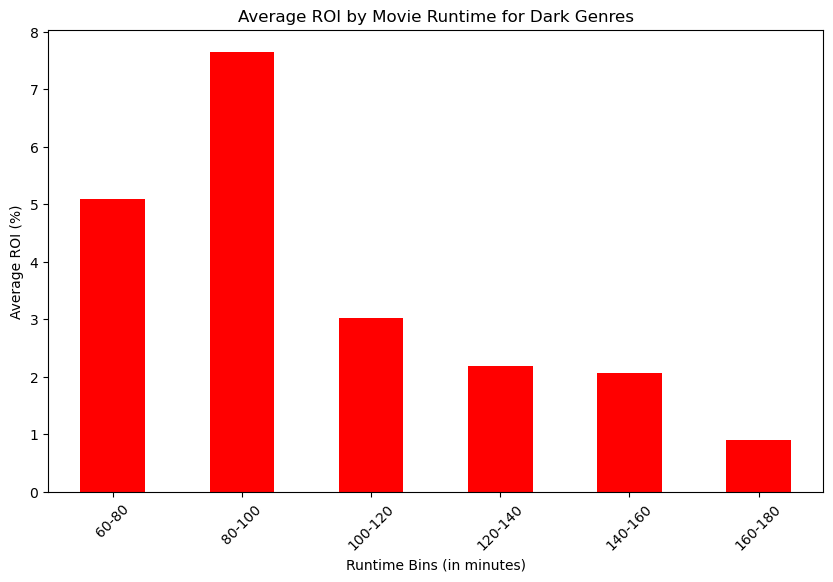

In [44]:
plt.figure(figsize=(10, 6))  # Set the figure size
dark_grouped_data.plot(kind='bar', color='red')  # Plot as a bar chart

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Dark Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(rotation=45)
plt.savefig("../Images/dark_avgroi_runtime_barchart.png", bbox_inches='tight')
# Show the plot
plt.show()

In [45]:
# Same for light genres
# Filter for specific genres: Musical, Animation, Family
light_genres_to_include = ['Musical', 'Animation', 'Family']
light_movies = info_budget_df[info_budget_df['genres'].str.contains('|'.join(light_genres_to_include), na=False)]

# Calculate the maximum runtime for defining the upper limit of the bins
light_max_runtime = light_movies['runtime_minutes'].max()

# Define runtime bins of 20 minutes each
bin_width = 20
bins = list(range(0, int(max_runtime) + bin_width, bin_width))

# Generate labels for the bins
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Bin the runtime data
light_movies['runtime_bin'] = pd.cut(light_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)

# Group by the new bins and calculate mean ROI
light_grouped_data = light_movies.groupby('runtime_bin', observed=True)['ROI%'].mean()

# Print the result
print(light_grouped_data)

runtime_bin
60-80      2.103170
80-100     2.727941
100-120    2.258910
120-140    2.265440
140-160    5.123791
160-180    3.068014
Name: ROI%, dtype: float64


/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/3905267674.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light_movies['runtime_bin'] = pd.cut(light_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)


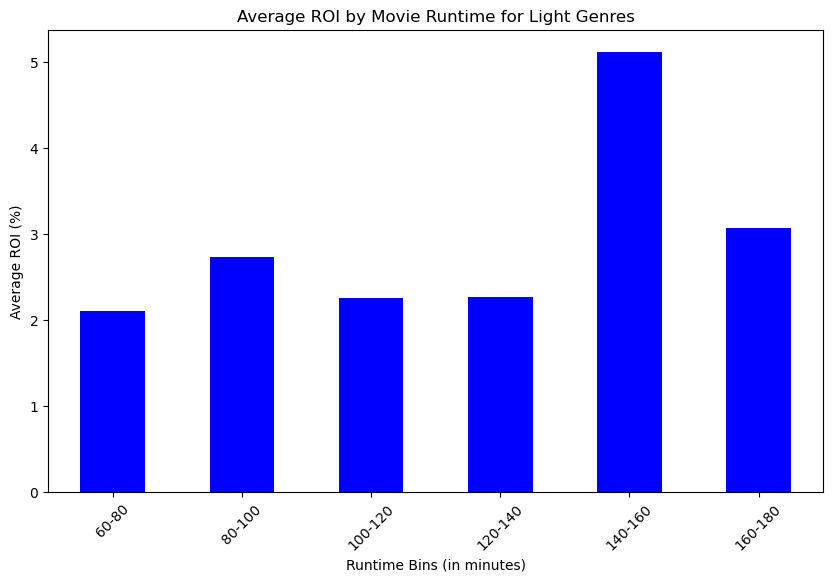

In [46]:
plt.figure(figsize=(10, 6))  # Set the figure size
light_grouped_data.plot(kind='bar', color='blue')  # Plot as a bar chart

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Light Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(rotation=45)
plt.savefig("../Images/light_avgroi_runtime_barchart.png", bbox_inches='tight')
# Show the plot
plt.show()

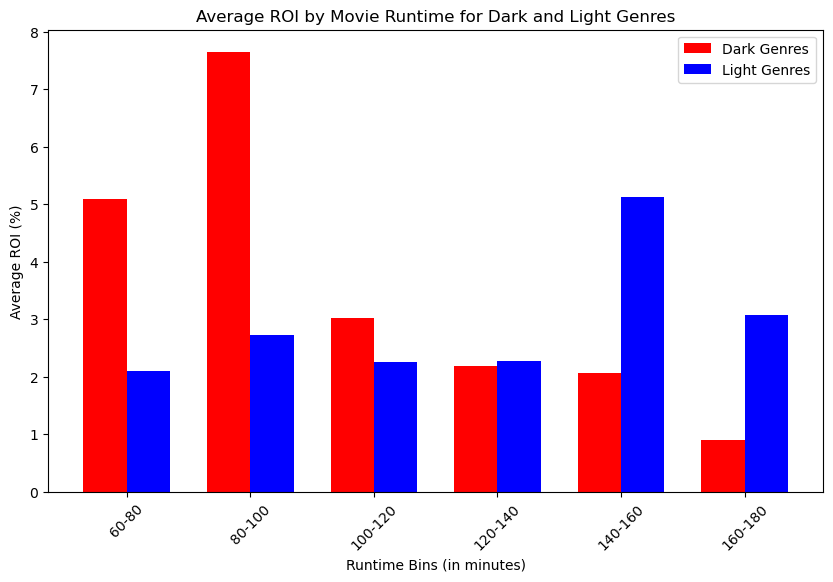

In [82]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the positions of the bars on the x-axis
n = len(dark_grouped_data)  # Number of data points (runtime bins)
ind = np.arange(n)  # the x locations for the groups
width = 0.35       # the width of the bars

# Create bars
plt.bar(ind - width/2, dark_grouped_data, width, color='red', label='Dark Genres')
plt.bar(ind + width/2, light_grouped_data, width, color='blue', label='Light Genres')

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Dark and Light Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(ind, dark_grouped_data.index, rotation=45)

# Add a legend
plt.legend()

# Save the figure
plt.savefig("../Images/combined_avgroi_runtime_barchart.png", bbox_inches='tight')

# Show the plot
plt.show()

In [47]:
# Standardize rating and number of votes
info_budget_df.columns

Index(['movie', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'net_revenue',
       'ROI%'],
      dtype='object')

In [48]:
info_budget_df.to_csv('../Data/info_budget.csv')

In [49]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [50]:
selected_movies = ['Musical', 'Animation', 'Family', 'Horror', 'Thriller', 'Mystery']
selected_movies_df = info_budget_df[info_budget_df['genres'].apply(lambda x: any(genre in x.split(',') for genre in selected_movies))]

In [51]:
# Create new dataframe containing only Light and Dark movies
# Drop all columns except movie name, light or dark categorization, average rating, number of votes, and ROI
def categorize_movie(genres):
    dark_genres = {'Horror', 'Thriller', 'Mystery'}
    light_genres = {'Animation', 'Family', 'Musical'}
    
    genres_set = set(genres.split(','))

    if genres_set & dark_genres:
        return 'Dark'
    elif genres_set & light_genres:
        return 'Light'
    else:
        return 'Other'

# Apply the function to create the 'movie_type' column
selected_movies_df['movie_type'] = selected_movies_df['genres'].apply(categorize_movie)

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/2595769946.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_movies_df['movie_type'] = selected_movies_df['genres'].apply(categorize_movie)


In [52]:
selected_movies_df.shape

(604, 11)

In [53]:
dark_movies_df = selected_movies_df.loc[selected_movies_df['movie_type'] == 'Dark']
light_movies_df = selected_movies_df.loc[selected_movies_df['movie_type'] == 'Light']

In [54]:
# Save the csvs
dark_movies_df.to_csv('../Data/genre_dfs/dark_movies_df.csv')
light_movies_df.to_csv('../Data/genre_dfs/light_movies_df.csv')
selected_movies_df.to_csv('../Data/genre_dfs/selected_movies_df.csv')

In [55]:
selected_movies_rating_volume_df = selected_movies_df.drop(columns = ['runtime_minutes', 'genres', 'production_budget', 'domestic_gross',
                                   'worldwide_gross', 'net_revenue'])

In [56]:
selected_movies_rating_volume_df['movie_type'].value_counts()

movie_type
Dark     431
Light    173
Name: count, dtype: int64

In [57]:
print('Light movies:')
light_movie_slim_df = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type'] == 'Light']
display(light_movie_slim_df.describe())
print('\n----------------------\n')
print('Dark movies:')
dark_movie_slim_df = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type'] == 'Dark']
display(dark_movie_slim_df.describe())

Light movies:


,averagerating,numvotes,ROI%
count,173.000000,173.000000,173.000000
mean,6.457803,111587.751445,2.519230
std,1.054233,131432.050113,2.829798
min,1.900000,5159.000000,-1.000000
25%,6.000000,23711.000000,0.797919
50%,6.600000,59486.000000,1.697980
75%,7.200000,146858.000000,3.331246
max,8.400000,719629.000000,14.680219



----------------------

Dark movies:


,averagerating,numvotes,ROI%
count,431.000000,4.310000e+02,431.000000
mean,6.164037,1.138290e+05,4.926551
std,0.902803,1.463874e+05,22.156101
min,3.200000,5.156000e+03,-1.000000
25%,5.600000,3.093750e+04,-0.338668
50%,6.200000,6.630300e+04,1.207960
75%,6.800000,1.271870e+05,3.452211
max,8.400000,1.387769e+06,415.564740


In [58]:
selected_movies_rating_volume_df['reduced_numvotes'] = selected_movies_rating_volume_df['numvotes'] / 1000

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/1815976410.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(
/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/1815976410.py:11: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.swarmplot(


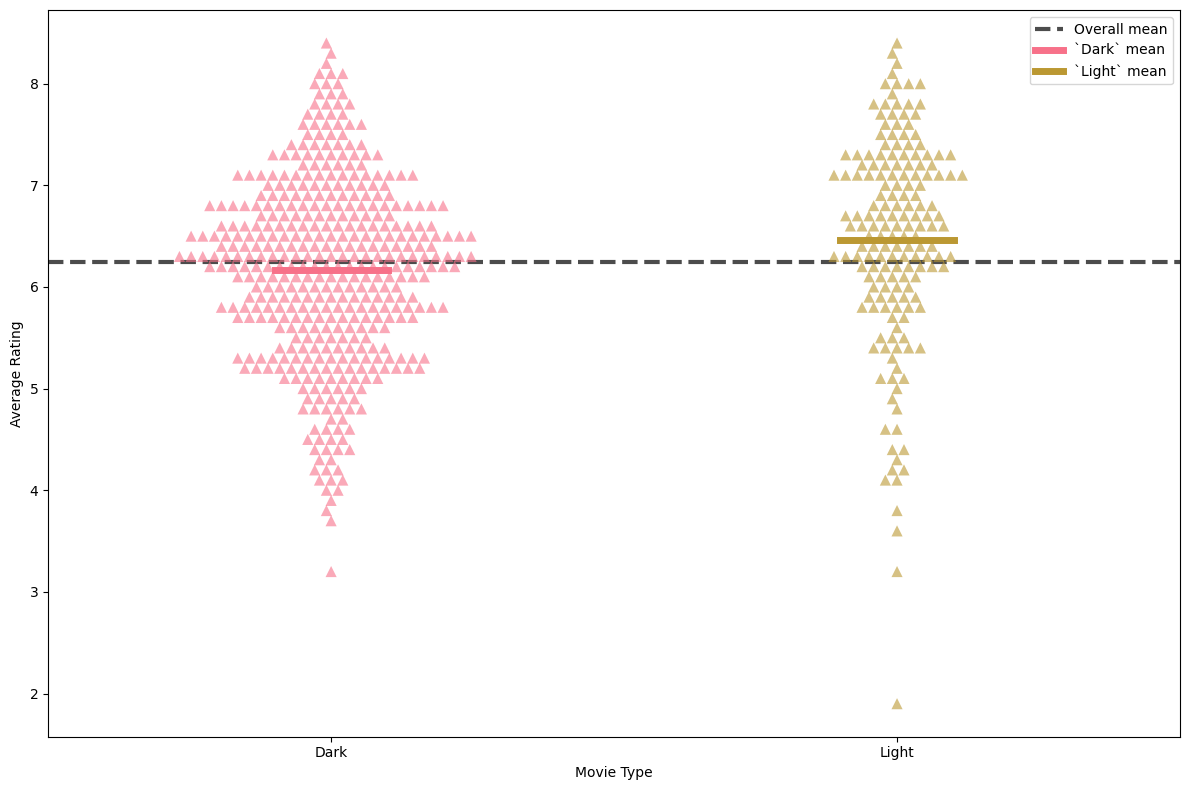

In [59]:
f, ax = plt.subplots(figsize=(12, 8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Select only two areas
selection_mask = (selected_movies_rating_volume_df['movie_type'] == 'Light')| (selected_movies_rating_volume_df['movie_type'] == 'Dark')
data_subset = selected_movies_rating_volume_df[selection_mask]

# Data Points
ax = sns.swarmplot(
    data=data_subset,
    x="movie_type",
    y="averagerating",
    ax=ax,
    alpha=0.6, 
    marker='^',
    size=8,
    palette=colors
)

ax.axhline(
    selected_movies_rating_volume_df['averagerating'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

ax.set_xlabel('Movie Type')
ax.set_ylabel('Average Rating')

# Look at each specifc group (by area)
movie_type = data_subset['movie_type'].unique()
for i, movie_type in enumerate(movie_type):
    mean = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type']==movie_type]['averagerating'].mean()
    if i == 0:
        xmin = .2
        xmax = .3
    else:
        xmin = .7
        xmax = .8
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{movie_type}` mean',
        lw=5, ls='-', color=colors[i]
    ) 

plt.savefig("../Images/film_type_avgrating_swarm.png", bbox_inches='tight')
ax.legend()
plt.tight_layout();

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/1860467846.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(
/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/1860467846.py:11: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.swarmplot(
/Users/nathan/opt/anaconda3/envs/learn-env-test/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 16.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nathan/opt/anaconda3/envs/learn-env-test/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 37.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarnin

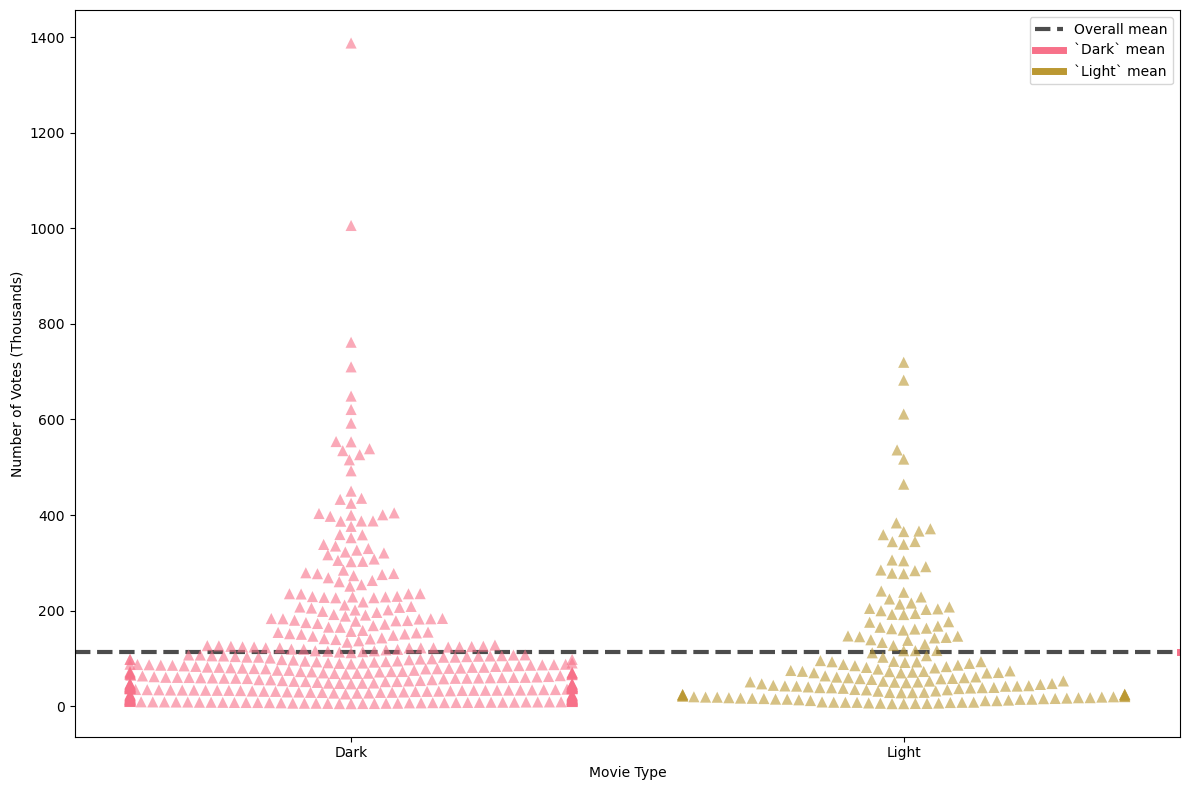

In [60]:
f, ax = plt.subplots(figsize=(12, 8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Select only two areas
selection_mask = (selected_movies_rating_volume_df['movie_type'] == 'Light') | (selected_movies_rating_volume_df['movie_type'] == 'Dark')
data_subset = selected_movies_rating_volume_df[selection_mask]

# Data Points
ax = sns.swarmplot(
    data=data_subset,
    x="movie_type",
    y="reduced_numvotes",
    ax=ax,
    alpha=0.6, 
    marker='^',
    size=8,
    palette=colors
)

ax.set_xlabel('Movie Type')
ax.set_ylabel('Number of Votes (Thousands)')

ax.axhline(
    selected_movies_rating_volume_df['reduced_numvotes'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

# Look at each specifc group
movie_type = data_subset['movie_type'].unique()
for i, movie_type in enumerate(movie_type):
    mean = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type']==movie_type]['reduced_numvotes'].mean()
    # Make these lines short and near each group
    xmin = 1/len(movie_type) * i + 1
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{movie_type}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
    
ax.legend()
plt.savefig("../Images/film_type_numvotes_swarm.png", bbox_inches='tight')
plt.tight_layout();

In [61]:
# Run a hyp test on Dark vs Light mean, variance - is their difference statistically significant?

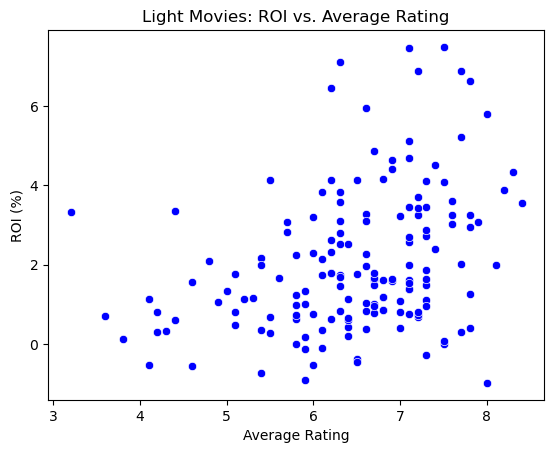

In [62]:
light_lower = light_movie_slim_df['ROI%'].quantile(0.01)
light_upper = light_movie_slim_df['ROI%'].quantile(0.95)

# Filter out the outliers
filtered_light_movie_slim_df = light_movie_slim_df[~((light_movie_slim_df['ROI%'] < light_lower) | (light_movie_slim_df['ROI%'] > light_upper))]

plt.figsize=(10, 8)
sns.scatterplot(x='averagerating', y='ROI%', data=filtered_light_movie_slim_df, color='blue')
plt.title('Light Movies: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')
plt.savefig("../Images/light_roi_vs_avgrating.png", bbox_inches='tight')
plt.show()

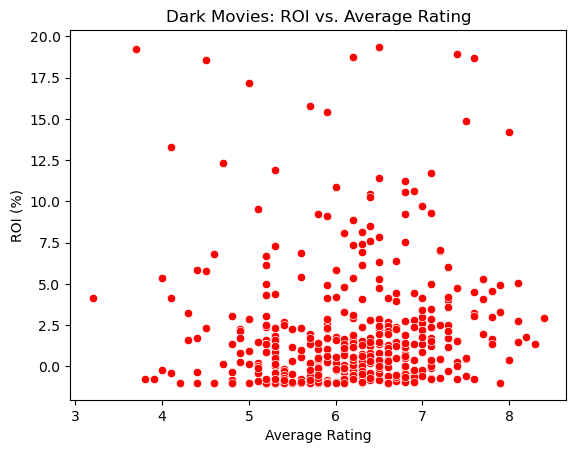

In [63]:
dark_lower = dark_movie_slim_df['ROI%'].quantile(0.01)
dark_upper = dark_movie_slim_df['ROI%'].quantile(0.95)

# Filter out the outliers
filtered_dark_movie_slim_df = dark_movie_slim_df[~((dark_movie_slim_df['ROI%'] < dark_lower) | (dark_movie_slim_df['ROI%'] > dark_upper))]

plt.figsize=(10, 8)
sns.scatterplot(x='averagerating', y='ROI%', data=filtered_dark_movie_slim_df, color='red')
plt.title('Dark Movies: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')
plt.savefig("../Images/dark_roi_vs_avgrating.png", bbox_inches='tight')
plt.show()

In [64]:
filtered_light_movie_slim_df['reduced_numvotes'] = filtered_light_movie_slim_df['numvotes'] / 1000

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/2317472617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_light_movie_slim_df['reduced_numvotes'] = filtered_light_movie_slim_df['numvotes'] / 1000


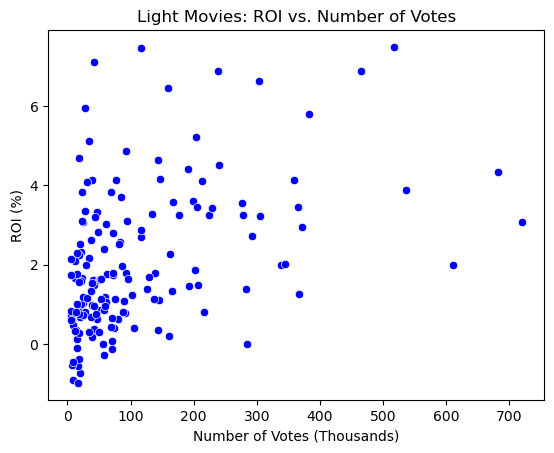

In [65]:
plt.figsize=(10, 8)
sns.scatterplot(x='reduced_numvotes', y='ROI%', data=filtered_light_movie_slim_df, color='blue')
plt.title('Light Movies: ROI vs. Number of Votes')
plt.xlabel('Number of Votes (Thousands)')
plt.ylabel('ROI (%)')
plt.savefig("../Images/light_roi_vs_numvotes.png", bbox_inches='tight')
plt.show()

In [66]:
filtered_dark_movie_slim_df['reduced_numvotes'] = filtered_dark_movie_slim_df['numvotes'] / 1000

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_91029/2514717878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dark_movie_slim_df['reduced_numvotes'] = filtered_dark_movie_slim_df['numvotes'] / 1000


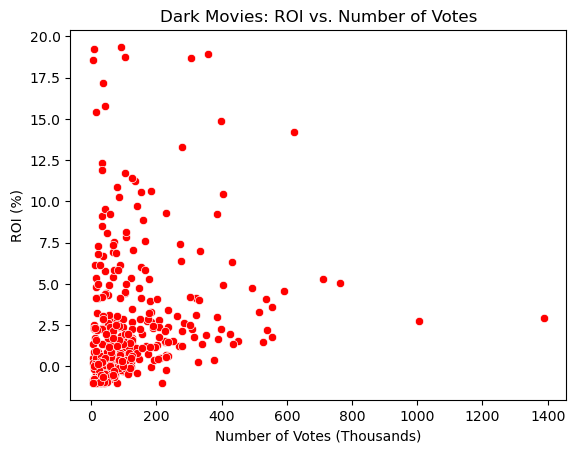

In [73]:
plt.figsize=(10, 8)
sns.scatterplot(x='reduced_numvotes', y='ROI%', data=filtered_dark_movie_slim_df, color='red')
plt.title('Dark Movies: ROI vs. Number of Votes')
plt.xlabel('Number of Votes (Thousands)')
plt.ylabel('ROI (%)')
plt.savefig("../Images/dark_roi_vs_numvotes.png", bbox_inches='tight')

plt.show()

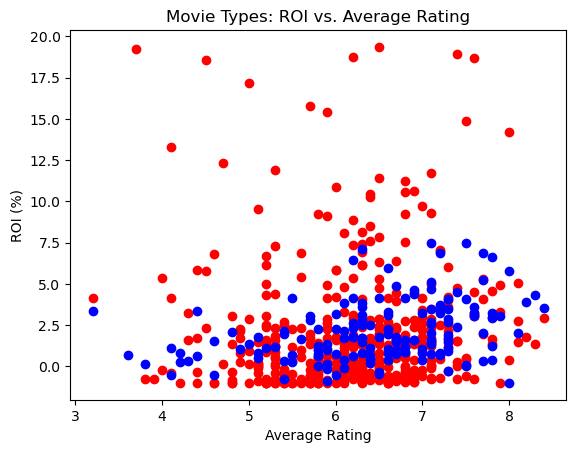

In [75]:
plt.scatter(filtered_dark_movie_slim_df['averagerating'], filtered_dark_movie_slim_df['ROI%'],color='red')
plt.scatter(filtered_light_movie_slim_df['averagerating'], filtered_light_movie_slim_df['ROI%'],color='blue')
plt.title('Movie Types: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')
plt.savefig("../Images/bothcats_roi_vs_avgrating_scatter.png", bbox_inches='tight')
plt.show()

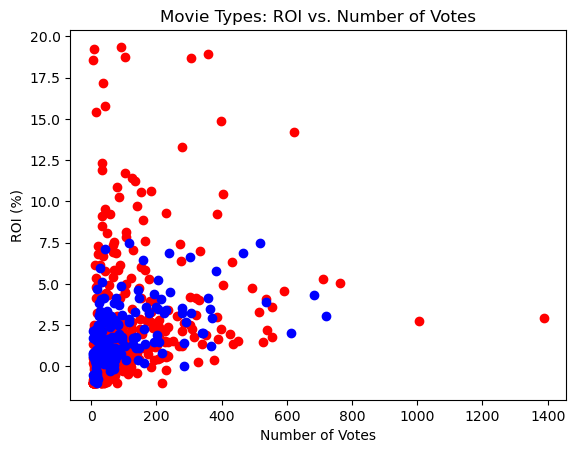

In [76]:
plt.scatter(filtered_dark_movie_slim_df['reduced_numvotes'], filtered_dark_movie_slim_df['ROI%'],color='red')
plt.scatter(filtered_light_movie_slim_df['reduced_numvotes'], filtered_light_movie_slim_df['ROI%'],color='blue')
plt.title('Movie Types: ROI vs. Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('ROI (%)')
plt.savefig("../Images/bothcats_roi_vs_numvotes_scatter.png", bbox_inches='tight')
plt.show()

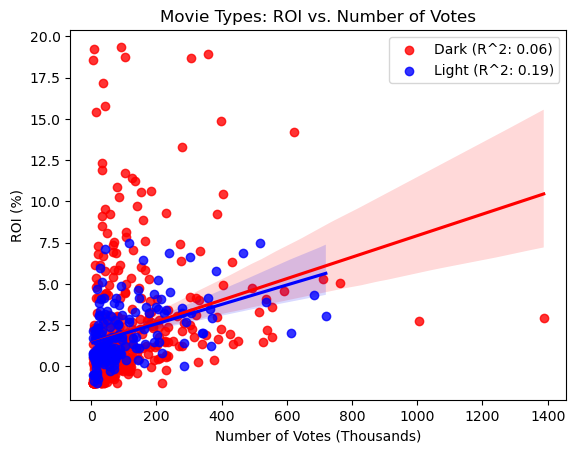

In [77]:
# Calculate correlation coefficients
r2_dark = (filtered_dark_movie_slim_df['reduced_numvotes'].corr(filtered_dark_movie_slim_df['ROI%']))**2
r2_light = (filtered_light_movie_slim_df['reduced_numvotes'].corr(filtered_light_movie_slim_df['ROI%']))**2

# Create scatter plots with regression lines
sns.regplot(x='reduced_numvotes', y='ROI%', data=filtered_dark_movie_slim_df, color='red', label=f'Dark (R^2: {r2_dark:.2f})')
sns.regplot(x='reduced_numvotes', y='ROI%', data=filtered_light_movie_slim_df, color='blue', label=f'Light (R^2: {r2_light:.2f})')

# Setting plot title and labels
plt.title('Movie Types: ROI vs. Number of Votes')
plt.xlabel('Number of Votes (Thousands)')
plt.ylabel('ROI (%)')

# Show legend
plt.legend()

plt.savefig("../Images/bothcats_roi_vs_numvotes_regplot.png", bbox_inches='tight')

# Display the plot
plt.show()

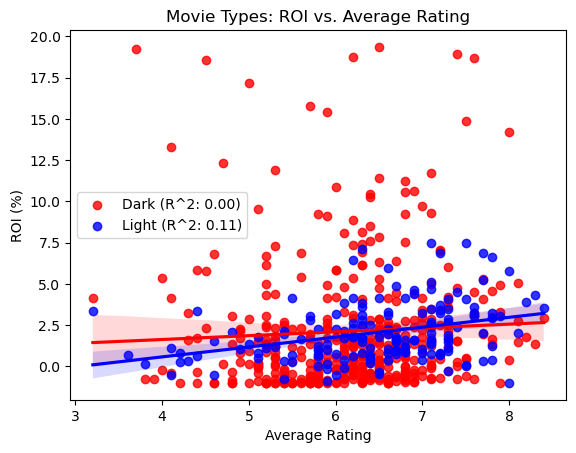

In [78]:
# Calculate correlation coefficients
r2_dark2 = (filtered_dark_movie_slim_df['averagerating'].corr(filtered_dark_movie_slim_df['ROI%']))**2
r2_light2 = (filtered_light_movie_slim_df['averagerating'].corr(filtered_light_movie_slim_df['ROI%']))**2

# Create scatter plots with regression lines
sns.regplot(x='averagerating', y='ROI%', data=filtered_dark_movie_slim_df, color='red', label=f'Dark (R^2: {r2_dark2:.2f})')
sns.regplot(x='averagerating', y='ROI%', data=filtered_light_movie_slim_df, color='blue', label=f'Light (R^2: {r2_light2:.2f})')

# Setting plot title and labels
plt.title('Movie Types: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')

# Show legend
plt.legend()

plt.savefig("../Images/bothcats_roi_vs_avgrating_regplot.png", bbox_inches='tight')

# Display the plot
plt.show()

In [72]:
# Create the folder if it doesn't exist
if not os.path.exists("../Data/genre_dfs"):
    os.makedirs("../Data/genre_dfs")

for name, df in genre_df_dict.items():
    # Define the complete file path
    file_path = os.path.join("../Data/genre_dfs", f"{name}.csv")
    
    # Save the dataframe to CSV
    df.to_csv(file_path, index=False)